In [15]:
import stepper as step
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pylab as plb

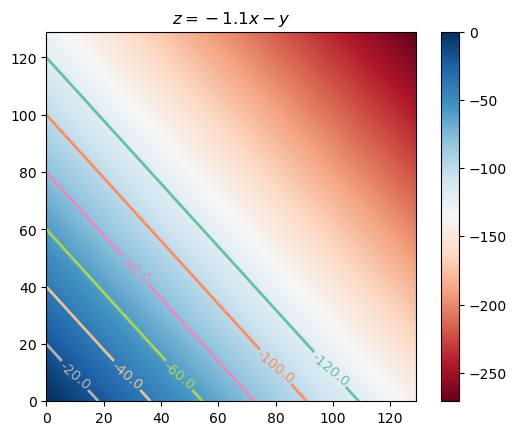

In [68]:
# the function that I'm going to plot
def z_func(x,y):
 return -1.1*x-y
 
x = np.arange(0,130,1)
y = np.arange(0,130,1)
X,Y = np.meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = plb.imshow(Z,extent=(x.min(), x.max(), y.min(), y.max()), origin='lower',cmap=plb.cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = plb.contour(X,Y,Z,np.arange(-120,0,20),linewidths=2,cmap=plb.cm.Set2)
plb.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plb.colorbar(im) # adding the colobar on the right
# latex fashion title
plb.title('$z=-1.1x-y$')
plb.show()

In [46]:
def fourBranch(x1, x2):
    g1 = 5 + 0.1 * (x1 - x2) ** 2 - (x1 + x2) / np.sqrt(2)
    g2 = 5 + 0.1 * (x1 - x2) ** 2 + (x1 + x2) / np.sqrt(2)
    g3 = (x1 - x2) + 9 / np.sqrt(2)
    g4 = (x2 - x1) + 9 / np.sqrt(2)

    return np.minimum.reduce((g1, g2, g3, g4))  # Min of all branches

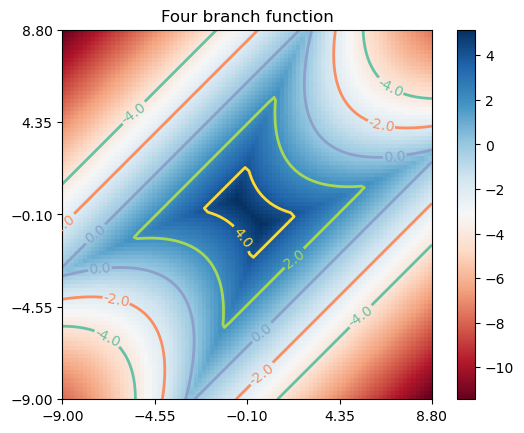

In [66]:
# the function that I'm going to plot
 
x = np.arange(-9,9,0.2)
y = np.arange(-9,9,0.2)
X,Y = np.meshgrid(x, y) # grid of point
Z = fourBranch(X, Y) # evaluation of the function on the grid

im = plb.imshow(Z,extent=(x.min(), x.max(), y.min(), y.max()), origin='lower',cmap=plb.cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = plb.contour(X,Y,Z,np.arange(-4,10,2),linewidths=2,cmap=plb.cm.Set2)
plb.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plb.colorbar(im) # adding the colobar on the right
plb.xticks(np.linspace(x.min(), x.max(), 5))  # Evenly spaced ticks on x-axis
plb.yticks(np.linspace(y.min(), y.max(), 5))  # Evenly spaced ticks on y-axis


# latex fashion title
plb.title('Four branch function')
plb.show()

In [12]:
sampler = stats.qmc.LatinHypercube(d=2)
sample = sampler.random(n=3)
scaled_sample = stats.qmc.scale(sample,0.1,0.3)
scaled_sample

array([[0.24272797, 0.19131266],
       [0.10404867, 0.245156  ],
       [0.20630181, 0.13206232]])

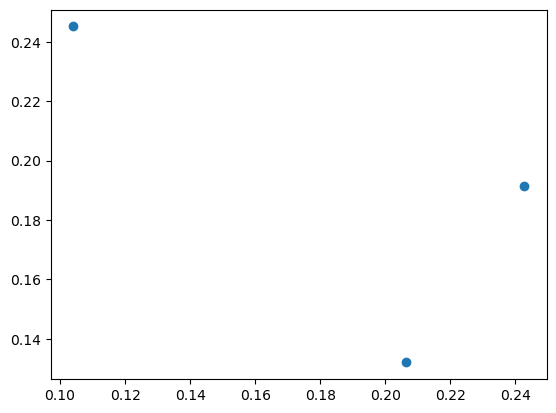

In [13]:
plt.scatter(scaled_sample[:,0],scaled_sample[:,1])

In [15]:
MAX_TIME = 5
N_RUN = 5000

In [3]:
transition_list = step.get_transitions()

In [16]:
# Monte carlo
X_monte,Y_monte,fail_times_monte = step.Monte_Carlo(transition_list,MAX_TIME,step.OBS_NAME,N_RUN)
p_f_monte = np.sum(Y_monte)/len(Y_monte)
print(f"failure proba at t={MAX_TIME}: {p_f_monte}")
print(f"CV estimation with {N_RUN}: {np.sqrt((1-p_f_monte)/(p_f_monte*N_RUN))}")

failure proba at t=5: 0.0132
CV estimation with 5000: 0.12227638836470085


In [1]:
transition_list

NameError: name 'transition_list' is not defined

In [149]:
lbd_1 = [transition_list[tr_index][2] for tr_index in range(len(transition_list))]

In [146]:
def AIS_CE(lbd_0,transition_list,obs_name,T,max_time,N,alpha,transition_index_list):
    """
    AIS_CE for p
    """
    n_tr = len(transition_list)
    quant_index = int(np.ceil(alpha*N))
    lbd = lbd_0.copy()
    # temporary lbd
    lbd_temp = lbd_0.copy()
    # current threshold time
    t_m = max_time
    n_rep = 0
    while t_m>T:
        print(f"t_m = {t_m}")
        # sampling density
        draw_f = [(lambda lbd_t=lbd_i: np.random.default_rng().exponential(scale=1/lbd_t)) for lbd_i in lbd]
        X_IS,_,fail_times_IS  = step.sample_IS(draw_f,transition_list,max_time,obs_name,N)
        # quantile of level alpha
        #print(fail_times_IS)
        #print(quant_index)
        t_alpha = sorted(fail_times_IS)[quant_index]
        print(sorted(fail_times_IS))
        print(t_alpha)
        if t_alpha == np.inf:
            raise Exception("There is less failure samples found than the alpha-quantile, to prevent this lower the quantile level alpha")
        t_m = max(t_alpha,T)
        # ratio between f_x|lbd_0 and f_x|lbd
        W = lambda x,lbd_0_w,lbd_w : np.prod([(lbd_0_w[tr_index]/lbd_w[tr_index]) for tr_index in transition_index_list])*np.exp(np.sum([-x[tr_index]*((lbd_0_w[tr_index]-lbd_w[tr_index])) for tr_index in transition_index_list]))
        #W = lambda x,lbd_0,lbd : np.prod([(lbd[tr_index]/lbd_0[tr_index]) for tr_index in range(n_tr)])*np.exp(np.sum([-x[tr_index]*((lbd[tr_index]-lbd_0[tr_index])/(lbd[tr_index]*lbd_0[tr_index])) for tr_index in range(n_tr)]))
        for tr_index in transition_index_list:
            lbd_num = 0
            lbd_denom = 0
            for sample_index in range(N):
                if fail_times_IS[sample_index]<=t_m :
                    W_i = W(X_IS[sample_index],lbd_0,lbd)
                    lbd_num+=W_i
                    lbd_denom+=W_i*X_IS[sample_index][tr_index]
            lbd_temp[tr_index] = lbd_num/lbd_denom
        lbd = lbd_temp.copy()
        # estimate probability and cv
        W_array = np.zeros(N)
        for sample_index in range(N):
            if fail_times_IS[sample_index]<=T :
                W_array[sample_index]=W(X_IS[sample_index],lbd_0,lbd)
        p_T = np.mean(W_array)
        cv = np.sqrt(np.var(W_array))/(np.sqrt(N)*p_T)
        print(f"current probability estimation: {p_T}")
        print(f"current cv estimation: {cv}")
        n_rep+=1
    # estimate probability and cv
    W_array = np.zeros(N)
    for sample_index in range(N):
        if fail_times_IS[sample_index]<=T :
            print(f"X = {X_IS[sample_index]}")
            #print(f"lbd ratio orders = {[(lbd[tr_index],lbd_0[tr_index],(lbd[tr_index]-lbd_0[tr_index])/(lbd[tr_index]*lbd_0[tr_index]),np.log10(np.exp(-X_IS[sample_index][tr_index]*((lbd[tr_index]-lbd_0[tr_index])/(lbd[tr_index]*lbd_0[tr_index]))))) for tr_index in range(n_tr) if X_IS[sample_index][tr_index]!=0.]}")
            #print(f"W order = {sum([np.log10(np.exp(-X_IS[sample_index][tr_index]*((lbd[tr_index]-lbd_0[tr_index])/(lbd[tr_index]*lbd_0[tr_index])))) for tr_index in range(n_tr) if X_IS[sample_index][tr_index]!=0.])}")
            print(f"W = {W(X_IS[sample_index],lbd_0,lbd)}")
            W_array[sample_index]=W(X_IS[sample_index],lbd_0,lbd)
    p_T = np.mean(W_array)
    cv = np.sqrt(np.var(W_array))/(np.sqrt(N)*p_T)
        
    return p_T,cv,lbd

In [134]:
draw_f = [(lambda lbd_t=lbd_i: np.random.default_rng().exponential(scale=1/lbd_t)) for lbd_i in lbd_1]
X_IS,Y_IS,fail_times_IS  = step.sample_IS(draw_f,transition_list,5,step.OBS_NAME,1000)

In [135]:
np.sum(Y_IS)/len(Y_IS)

0.013

In [106]:
np.sum(Y_IS)/len(Y_IS)

0.186

In [153]:
lbd_1

[0.01, 0.01, 0.1]

In [157]:
lbd

[0.3281703755913673, 0.011441180320497587, 0.4789344965249716]

In [152]:
p_fA,cvA,lbd = AIS_CE(lbd_1,transition_list,step.OBS_NAME,5,200,500,0.3,[i for i in range(len(transition_list))])

t_m = 200
[0.7907245120532881, 1.703562874880745, 2.790451739464717, 4.1204493177874735, 5.552606454058588, 5.728348778792908, 5.962001642129899, 6.343465548115603, 6.934392879606829, 7.789886439481389, 8.25202552433369, 8.563839905716076, 9.485837211110624, 9.941892610485645, 10.361877811797052, 11.041219136105864, 11.360670289889038, 12.74277244496733, 13.237857932092512, 13.316286825813487, 13.351335593887557, 13.725865389238894, 13.884108384666774, 14.809182743250588, 15.343241278543829, 15.760756226688006, 16.141987953404616, 16.20935632052727, 16.49412562763577, 16.536788734473635, 16.78541938827582, 17.2870620005228, 17.317325674710126, 17.54894248216951, 17.664603965082197, 17.728994501132934, 17.72916237531122, 18.610559878697778, 18.75827946121381, 19.058278438621628, 19.45219476873589, 19.56637870954997, 19.579013075993647, 19.587764878972887, 19.884170227364837, 20.069241370695465, 20.150963592476977, 20.28667327113606, 20.563344029398987, 20.818767975579647, 20.98472208095

In [5]:
X_monte,Y_monte = step.Monte_Carlo(transition_list,MAX_TIME,step.OBS_NAME,N_RUN//10)
p_f_monte = np.sum(Y_monte)/len(Y_monte)
print(f"failure proba at t={MAX_TIME}: {p_f_monte}")
print(f"CV estimation with {N_RUN//10}: {np.sqrt((1-p_f_monte)/(p_f_monte*N_RUN))}")

failure proba at t=5: 0.0
CV estimation with 100: inf


C:\Users\jo.mboko\AppData\Local\Temp\ipykernel_19448\1674515803.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"CV estimation with {N_RUN//10}: {np.sqrt((1-p_f_monte)/(p_f_monte*N_RUN))}")


In [6]:
#IS 
X_is,Y_is,p_f,cv = step.simple_IS(transition_list,MAX_TIME,0.5,step.OBS_NAME,N_RUN//10)
print(f"failure proba at t={MAX_TIME}: {p_f}")
print(f"CV estimation with {N_RUN//10}: {cv}")

failure proba at t=5: 0.01734221856913399
CV estimation with 100: 0.20634973206400214


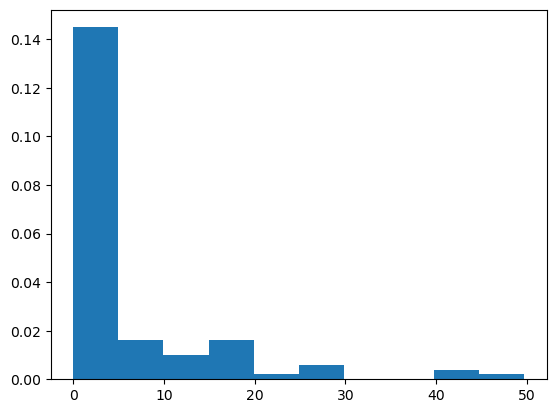

In [9]:
plt.hist(X_is[:,2],density=True,bins=10)
plt.show()

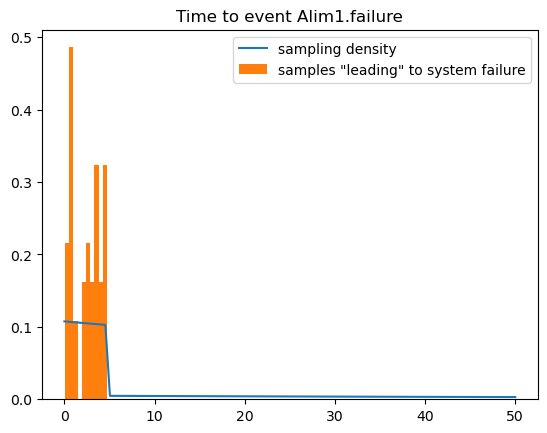

KstestResult(statistic=0.5049860824525614, pvalue=5.691865319851543e-10, statistic_location=4.713236768403597, statistic_sign=1)


In [69]:
x_index = 0
x_space = np.linspace(0,10*MAX_TIME,100)
lbd = transition_list[x_index][2]
c = 0.5
g = lambda x: (x<=MAX_TIME)*(1+c*(np.exp(-lbd*MAX_TIME)/(1-np.exp(-lbd*MAX_TIME))))*(lbd*np.exp(-lbd*x))+(x>MAX_TIME)*(1-c)*(lbd*np.exp(-lbd*x))
plt.plot(x_space,g(x_space),label="sampling density")
plt.hist(X_is[:,x_index][Y_is==1.],density=True,label="samples \"leading\" to system failure",bins=10)
plt.title(f"Time to event {transition_list[x_index][1]}")
plt.legend()
plt.show()

# test ks
# cdf corresponding to g
G = lambda x: (x<=MAX_TIME)*(1+c*(np.exp(-lbd*MAX_TIME)/(1-np.exp(-lbd*MAX_TIME))))*(1-np.exp(-lbd*x))+(x>MAX_TIME)*((1+c*(np.exp(-lbd*MAX_TIME)/(1-np.exp(-lbd*MAX_TIME))))*(1-np.exp(-lbd*MAX_TIME))+(1-c)*(np.exp(-lbd*MAX_TIME)-np.exp(-lbd*x)))

print(stats.kstest(X_is[:,x_index][Y_is==1.],G))

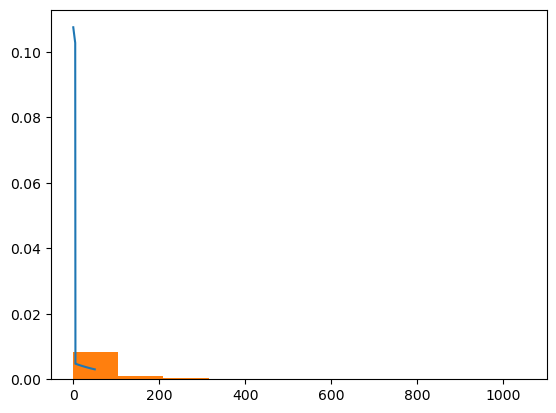

KstestResult(statistic=0.0730692241511641, pvalue=0.6328434200005224, statistic_location=0.9994904710356611, statistic_sign=1)


In [70]:
plt.plot(x_space,g(x_space))
plt.hist(X_is[:,x_index],density=True,bins=10)
plt.show()
print(stats.kstest(X_is[:,x_index],G))